In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, ELU, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix

2025-03-20 16:10:23.610462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742479823.627392    4561 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742479823.632868    4561 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 16:10:23.650405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Constants
IMG_SIZE = (320, 320)  
BATCH_SIZE = 8
EPOCHS = 50
DATA_PATH = "../MURA-v1.1"
TRAIN_PATH = DATA_PATH + "/train_labeled_studies.csv"
VALID_PATH = DATA_PATH + "/valid_labeled_studies.csv"


In [20]:
# Load Data
def load_data(csv_path):
    df = pd.read_csv(csv_path, names=['Path', 'Label'], header=None)
    image_paths, labels = [], []
    base_dir = "../"  # Root dataset directory
    for _, row in df.iterrows():
        study_path = os.path.join(base_dir, row["Path"])
        label = row["Label"]
        for image_file in os.listdir(study_path):
            image_path = os.path.join(study_path, image_file)
            if image_path.endswith(".png") and not image_file.startswith("._"):
                image_paths.append(image_path)
                labels.append(label)
    return np.array(image_paths), np.array(labels)

In [21]:
train_image_paths, train_labels = load_data(TRAIN_PATH)
valid_image_paths, valid_labels = load_data(VALID_PATH)
X_train, X_test, y_train, y_test = train_test_split(train_image_paths, train_labels, test_size=0.1, stratify=train_labels, random_state=42)


In [22]:
# Convert labels into a Pandas Series
todf = pd.Series(train_labels)

# Count occurrences of each class
class_counts = todf.value_counts().to_dict()

# Get the counts (handle cases where labels might be missing)
NormalCount = class_counts.get(0, 0)  # Normal (0)
AbnormalCount = class_counts.get(1, 0)  # Abnormal (1)

# Compute class weights
w1 = NormalCount / (NormalCount + AbnormalCount)  # Weight for class 0
w2 = AbnormalCount / (NormalCount + AbnormalCount)  # Weight for class 1

class_weights = {0: w2, 1: w1}  # More weight to minority class
print("Class Weights:", class_weights)

Class Weights: {0: 0.40406976744186046, 1: 0.5959302325581395}


In [23]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [29]:
class MURADataGenerator(Sequence):
    def __init__(self, image_paths, labels, class_weights, batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False, shuffle=True):
        # Initialize empty lists to store the modified dataset
        self.image_paths = []
        self.labels = []

        # Duplicate entries for label 1
        for path, label in zip(image_paths, labels):
            self.image_paths.append(path)
            self.labels.append(label)
            if label == 1 and augment == True and shuffle==True :  # For label 1, add the image and label again
                self.image_paths.append(path)
                self.labels.append(label)

        self.class_weights = class_weights  # Store class weights
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.datagen = train_datagen if augment else None
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate images and labels
        X, y = self.__data_generation(batch_paths, batch_labels)

        # Generate sample weights based on labels
        sample_weights = np.array([self.class_weights[label] for label in batch_labels])

        return X, y, sample_weights  # Return (X, y, sample_weights)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)

    def __data_generation(self, batch_paths, batch_labels):
        images = []
        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0  # Normalize
            img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
            if self.augment:
                img = self.datagen.random_transform(img)
            images.append(img)
        return np.array(images).reshape(-1, *self.img_size, 3), np.array(batch_labels)


In [30]:
# Generators
train_generator = MURADataGenerator(X_train, y_train,class_weights, augment=True)
valid_generator = MURADataGenerator(valid_image_paths, valid_labels,class_weights, augment=False, shuffle=False)
test_generator = MURADataGenerator(X_test, y_test,class_weights, augment=False, shuffle=False)


In [9]:
# Load Pretrained Model
base_model = DenseNet169(weights='imagenet', include_top=False, input_tensor=Input(shape=(*IMG_SIZE, 3)))


I0000 00:00:1742479827.360990    4561 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4471 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
# Gradually Unfreeze Layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [11]:
# Add Custom Classifier Head
x = Flatten()(base_model.output)
x = Dense(units=128, kernel_initializer='he_normal', kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = ELU(alpha=1.0)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


In [12]:
# Compile Model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)  # Changed to False for ensembling
model_checkpoint = ModelCheckpoint(
    "model2_dense.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [14]:

# Train Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 320, 320, 3))
  warnings.warn(msg)
I0000 00:00:1742479848.756651    4595 service.cc:148] XLA service 0x74b8cc003630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742479848.756668    4595 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-03-20 16:10:49.324965: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742479852.243181    4595 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-03-20 16:10:54.471081: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_

   1/5815 ━━━━━━━━━━━━━━━━━━━━ 64:22:32 40s/step - accuracy: 0.3750 - loss: 5.5805

2025-03-20 16:11:11.335471: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_35', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_38', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_39', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1742479871.432245    4595 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6374 - loss: 1.1221

2025-03-20 16:38:24.272858: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-20 16:38:24.355561: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-20 16:38:25.005171: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 0.38898, saving model to model2_dense.h5


5815/5815 ━━━━━━━━━━━━━━━━━━━━ 1683s 283ms/step - accuracy: 0.6374 - loss: 1.1220 - val_accuracy: 0.7354 - val_loss: 0.3890 - learning_rate: 1.0000e-04
Epoch 2/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6983 - loss: 0.3859
Epoch 2: val_loss improved from 0.38898 to 0.31245, saving model to model2_dense.h5


5815/5815 ━━━━━━━━━━━━━━━━━━━━ 953s 164ms/step - accuracy: 0.6983 - loss: 0.3859 - val_accuracy: 0.7571 - val_loss: 0.3124 - learning_rate: 1.0000e-04
Epoch 3/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7211 - loss: 0.3358
Epoch 3: val_loss improved from 0.31245 to 0.29119, saving model to model2_dense.h5


5815/5815 ━━━━━━━━━━━━━━━━━━━━ 890s 153ms/step - accuracy: 0.7211 - loss: 0.3358 - val_accuracy: 0.7724 - val_loss: 0.2912 - learning_rate: 1.0000e-04
Epoch 4/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7380 - loss: 0.3099
Epoch 4: val_loss improved from 0.29119 to 0.27416, saving model to model2_dense.h5


5815/5815 ━━━━━━━━━━━━━━━━━━━━ 949s 163ms/step - accuracy: 0.7380 - loss: 0.3099 - val_accuracy: 0.7798 - val_loss: 0.2742 - learning_rate: 1.0000e-04
Epoch 5/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7470 - loss: 0.3006
Epoch 5: val_loss improved from 0.27416 to 0.27026, saving model to model2_dense.h5


5815/5815 ━━━━━━━━━━━━━━━━━━━━ 933s 160ms/step - accuracy: 0.7470 - loss: 0.3006 - val_accuracy: 0.7774 - val_loss: 0.2703 - learning_rate: 1.0000e-04
Epoch 6/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7517 - loss: 0.2950
Epoch 6: val_loss did not improve from 0.27026
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 925s 159ms/step - accuracy: 0.7517 - loss: 0.2950 - val_accuracy: 0.7851 - val_loss: 0.2729 - learning_rate: 1.0000e-04
Epoch 7/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7589 - loss: 0.2923
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 7: val_loss did not improve from 0.27026
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 920s 158ms/step - accuracy: 0.7589 - loss: 0.2923 - val_accuracy: 0.7679 - val_loss: 0.3034 - learning_rate: 1.0000e-04
Epoch 8/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7708 - loss: 0.2655
Epoch 8: val_loss improved from 0.27026 to 0.24091, saving model to model2_dense.h5


5815/5815 ━━━━━━━━━━━━━━━━━━━━ 966s 166ms/step - accuracy: 0.7708 - loss: 0.2655 - val_accuracy: 0.7990 - val_loss: 0.2409 - learning_rate: 5.0000e-05
Epoch 9/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7809 - loss: 0.2555
Epoch 9: val_loss did not improve from 0.24091
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 961s 165ms/step - accuracy: 0.7809 - loss: 0.2555 - val_accuracy: 0.7844 - val_loss: 0.2517 - learning_rate: 5.0000e-05
Epoch 10/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7883 - loss: 0.2526
Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 10: val_loss did not improve from 0.24091
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 975s 168ms/step - accuracy: 0.7883 - loss: 0.2526 - val_accuracy: 0.7884 - val_loss: 0.2518 - learning_rate: 5.0000e-05
Epoch 11/50
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7980 - loss: 0.2357
Epoch 11: val_loss did not improve from 0.24091
5815/5815 ━━━━━━━━━━━━━━━━━━━━ 932s 160ms/step - accur

In [15]:
import json

# Save history
with open('history2.json', 'w') as f:
    json.dump(history.history, f)

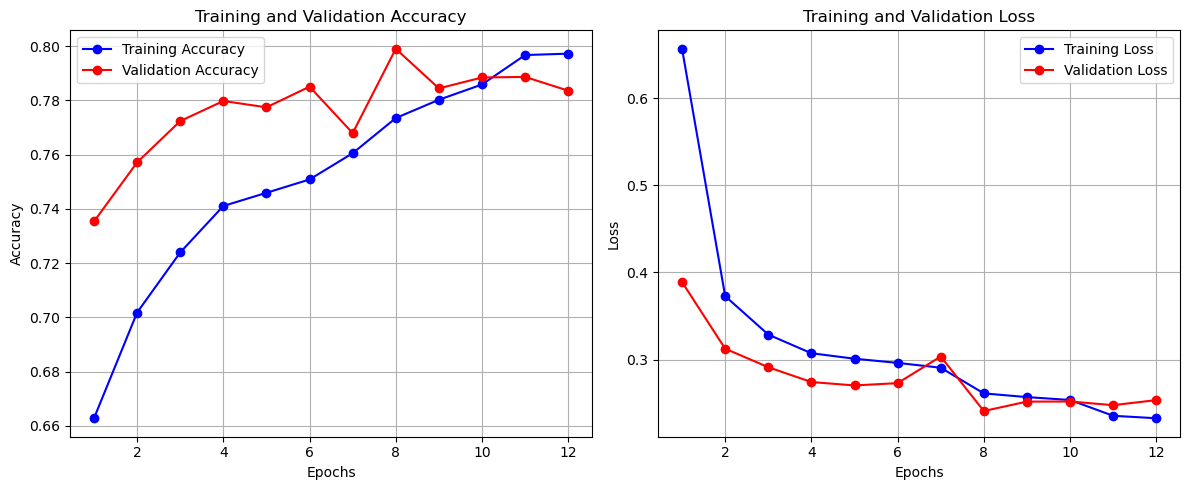

In [26]:
# Load the history from the JSON file
history_path = "history2.json"  # Update with the correct path if needed
with open(history_path, "r") as file:
    history = json.load(file)

# Extract values
epochs = range(1, len(history["accuracy"]) + 1)
train_acc = history["accuracy"]
val_acc = history["val_accuracy"]
train_loss = history["loss"]
val_loss = history["val_loss"]

# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [32]:
pred=model.predict(test_generator)

460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 320, 320, 3))
  warnings.warn(msg)


461/461 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step


## image level performance

In [33]:
import numpy as np
# Ensure predictions are flattened
predictions = pred.flatten()
predictions = (predictions > 0.5).astype(int)
# Convert to NumPy arrays
y_test = np.array(y_test).astype(int)
predictions = np.array(predictions).astype(int)

# Count correct and incorrect predictions
true_positives = np.sum((predictions == 1) & (y_test == 1))
true_negatives = np.sum((predictions == 0) & (y_test == 0))
false_positives = np.sum((predictions == 1) & (y_test == 0))
false_negatives = np.sum((predictions == 0) & (y_test == 1))

# Print results
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

# Calculate accuracy
accuracy = (true_positives + true_negatives) / len(y_test)
print(f"Calculated Accuracy: {accuracy * 100:.2f}%")

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.2f}")
from sklearn.metrics import cohen_kappa_score

# Compute Cohen's Kappa
kappa = cohen_kappa_score(y_test, predictions)
print(f"Cohen's Kappa: {kappa:.2f}")


True Positives: 1198
True Negatives: 1644
False Positives: 550
False Negatives: 289
Calculated Accuracy: 77.21%
Precision: 0.69
Recall: 0.81
F1-Score: 0.74
Cohen's Kappa: 0.54
